In [1]:
import sys
sys.path.append('../src')
import exlib
import torch
from datasets import load_dataset
from exlib.datasets import massmaps
from exlib.datasets.massmaps import MassMapsConvnetForImageRegression

device = torch.device("cuda") if torch.cuda.is_available() else torch.device("cpu")

In [2]:
# Load model
model = MassMapsConvnetForImageRegression.from_pretrained(massmaps.MODEL_REPO) # BrachioLab/massmaps-conv
model = model.to(device)

/home/runai-home/.local/lib/python3.10/site-packages/huggingface_hub/file_download.py:1132: FutureWarning: `resume_download` is deprecated and will be removed in version 1.0.0. Downloads always resume when possible. If you want to force a new download, use `force_download=True`.
  warnings.warn(


In [3]:
# Load data
train_dataset = load_dataset(massmaps.DATASET_REPO, split='train') # BrachioLab/massmaps-cosmogrid-100k
val_dataset = load_dataset(massmaps.DATASET_REPO, split='validation')
test_dataset = load_dataset(massmaps.DATASET_REPO, split='test')
train_dataset.set_format('torch', columns=['input', 'label'])
val_dataset.set_format('torch', columns=['input', 'label'])
test_dataset.set_format('torch', columns=['input', 'label'])

In [64]:
# Baseline

from skimage.segmentation import watershed, quickshift
from scipy import ndimage
from skimage.feature import peak_local_max
import sys
sys.path.append('../src')
from exlib.explainers.common import convert_idx_masks_to_bool
import torch
import torch.nn as nn
import numpy as np

class MassMapsWatershed(nn.Module):
    def __init__(self, compactness=0):
        super().__init__()
        self.compactness = compactness
        
    def apply_watershed(self, image):
        compactness = self.compactness
        
        image = (image * 255).astype(np.uint8)
        distance = ndimage.distance_transform_edt(image)
        coords = peak_local_max(distance, min_distance=10, labels=image)
        mask = np.zeros(distance.shape, dtype=bool)
        mask[tuple(coords.T)] = True
        markers, _ = ndimage.label(mask)
        raw_labels = watershed(-distance, markers, mask=image,
                               compactness=compactness)
        return raw_labels
    
    def forward(self, images):
        """
        input: images (N, C=1, H, W)
        output: daf_preds (N, H, W)
        """
        daf_preds = []
        for image in images:
            segment_mask = torch.tensor(self.apply_watershed(image[0].cpu().numpy())).to(images.device)
            masks_bool = convert_idx_masks_to_bool(segment_mask[None])
            daf_preds.append(masks_bool)
        daf_preds = torch.nn.utils.rnn.pad_sequence(daf_preds, batch_first=True)
        return daf_preds

In [14]:
watershed_baseline = MassMapsWatershed().to(device)

In [61]:
# Alignment
from exlib.datasets.massmaps import MassMapsAlignment
massmaps_align = MassMapsAlignment()

In [71]:
# Eval
batch_size = 5
test_dataloader = torch.utils.data.DataLoader(test_dataset, batch_size=batch_size)

import torch.nn.functional as F
from tqdm.auto import tqdm

model.eval()
mse_loss_all = 0
total = 0
alignment_scores_all = []
groups = []

with torch.no_grad():
    for bi, batch in tqdm(enumerate(test_dataloader), total=len(test_dataloader)):
        X = batch['input'].to(device)
        y = batch['label'].to(device)
        out = model(X)
        # loss
        loss = F.mse_loss(out, y, reduction='none')
        mse_loss_all = mse_loss_all + loss.sum(0)
        total += X.shape[0]

        # baseline
        zp = watershed_baseline(X)

        # alignment
        alignment_scores = massmaps_align(zp, X)
        for i in range(X.shape[0]):
            alignment_scores_all.append(alignment_scores[i][zp[i].sum([-1,-2]) > 0].cpu().numpy().tolist())
            groups.append(zp[i][zp[i].sum([-1,-2]) > 0].cpu().numpy().tolist())
            
        if bi > 100:
            break
            
loss_avg = mse_loss_all / total

print(f'Omega_m loss {loss_avg[0].item():.4f}, sigma_8 loss {loss_avg[1].item():.4f}, avg loss {loss_avg.mean().item():.4f}')

  0%|          | 0/2000 [00:00<?, ?it/s]

Omega_m loss 0.0048, sigma_8 loss 0.0114, avg loss 0.0081


In [72]:
torch.mean(torch.stack([torch.mean(torch.tensor(alignment_scores_all[i])) \
                      for i in range(len(alignment_scores_all))]))


tensor(0.1300)

# Show alignment scores examples

In [15]:
import torch
from exlib.datasets.massmaps import MassMapsAlignment
watershed_baseline = MassMapsWatershed().to(device)
X, y = train_dataset[0:2]['input'], train_dataset[0:2]['label']
zp = watershed_baseline(X)
print('X', X.shape)
print('y', y.shape)
print('zp', zp.shape)
massmaps_align = MassMapsAlignment()
alignment_scores_void, alignment_scores_cluster = massmaps_align(zp, X, reduce='none')
print('alignment_scores_void', alignment_scores_void.shape)
print('alignment_scores_cluster', alignment_scores_cluster.shape)

X torch.Size([2, 1, 66, 66])
y torch.Size([2, 2])
zp torch.Size([2, 75, 66, 66])
alignment_scores_void torch.Size([2, 75])
alignment_scores_cluster torch.Size([2, 75])


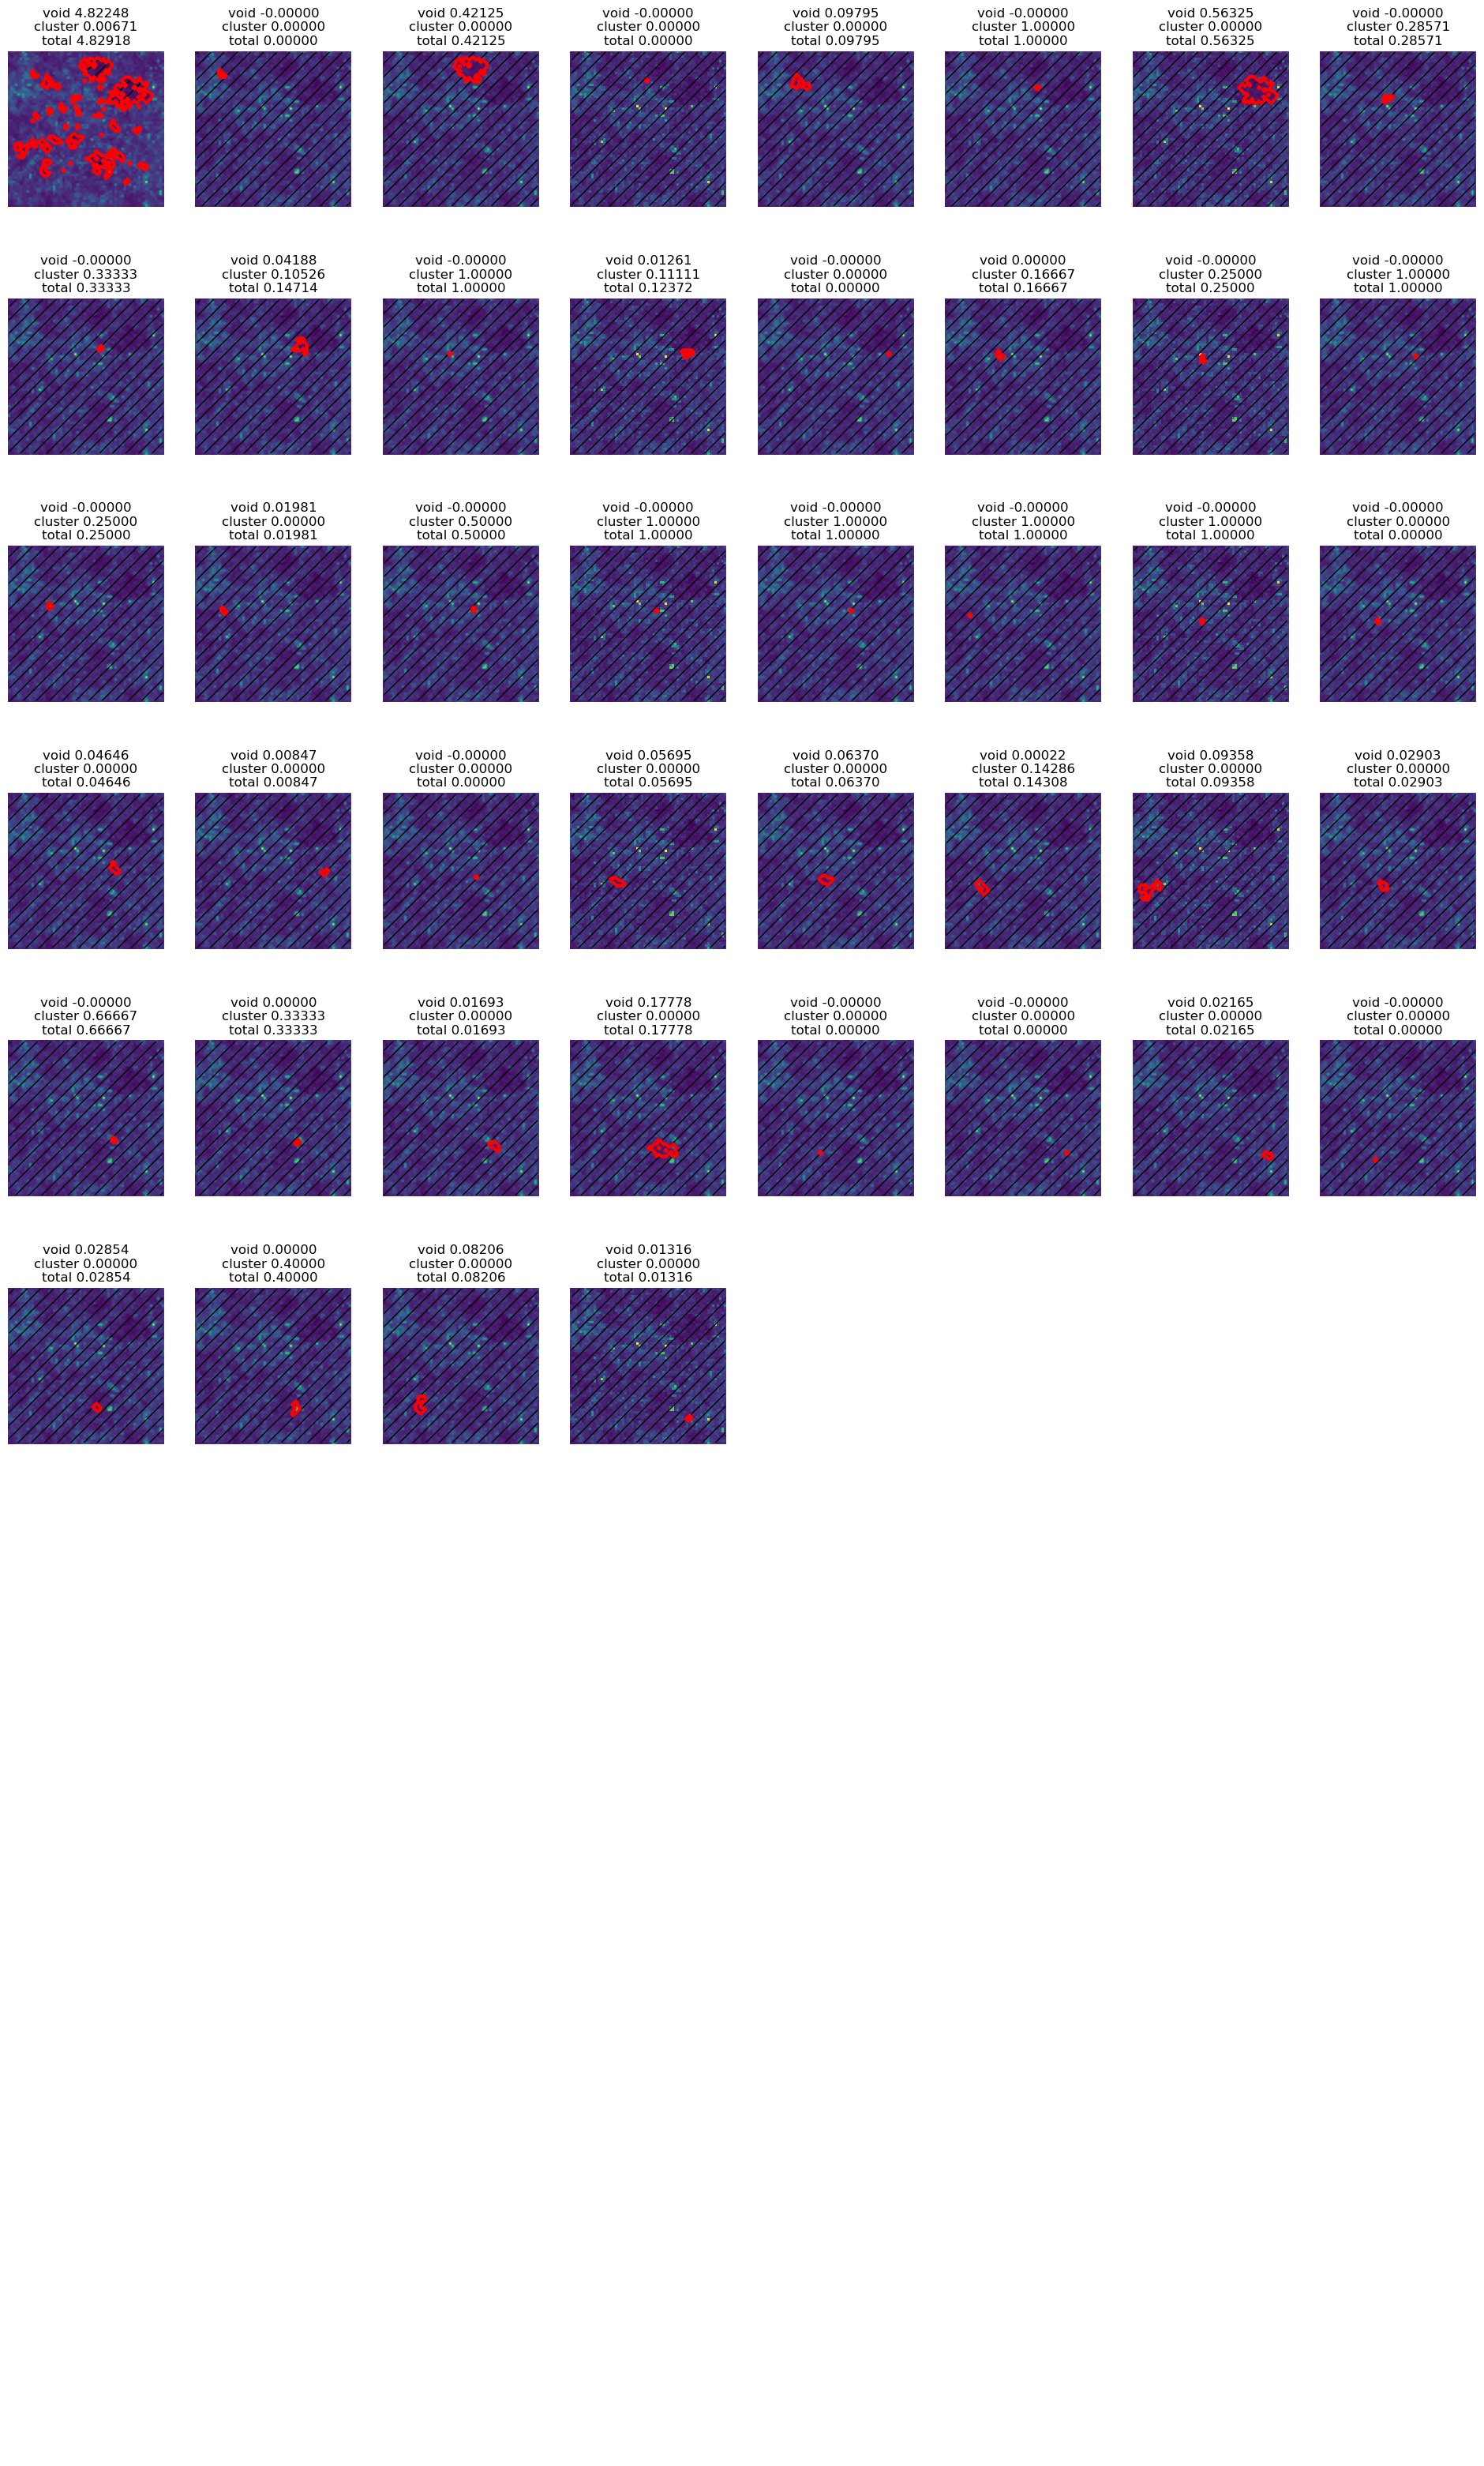

In [13]:
import matplotlib.pyplot as plt
import math

img_idx = 0
m = zp.shape[1]
cols = 8
rows = math.ceil(m / cols)
fig, axs = plt.subplots(rows, cols, figsize=(cols*3, rows*4))
axs = axs.ravel()

image = X[img_idx]
for idx in range(len(axs)):
    if idx < m:
        mask = zp[img_idx][idx]

        if mask.sum() > 0:
            axs[idx].imshow(image[0].cpu().numpy())
            axs[idx].contour(mask.cpu().numpy() > 0, 2, colors='red')
            axs[idx].contourf(mask.cpu().numpy() > 0, 2, hatches=['//', None, None],
                            cmap='gray', extend='neither', linestyles='--', alpha=0.01)
            total_score = alignment_scores_void[0][idx].item() * massmaps_align.void_scale + alignment_scores_cluster[0][idx].item() * massmaps_align.cluster_scale
            axs[idx].set_title(f'void {alignment_scores_void[0][idx].item():.5f}\ncluster {alignment_scores_cluster[0][idx].item():.5f}\ntotal {total_score:.5f}')
    axs[idx].axis('off')
plt.show()
          

In [65]:
# Quickshift

from skimage.segmentation import watershed, quickshift
from scipy import ndimage
from skimage.feature import peak_local_max
import sys
sys.path.append('../src')
from exlib.explainers.common import convert_idx_masks_to_bool
import torch
import torch.nn as nn
import numpy as np
import cv2

class MassMapsQuickshift(nn.Module):
    def __init__(self, ratio=1.0, kernel_size=5, max_dist=10):
        super().__init__()
        self.ratio = ratio
        self.kernel_size = kernel_size
        self.max_dist = max_dist
        
    def apply_quickshift(self, image):
        """
        ratio : float, optional, between 0 and 1
            Balances color-space proximity and image-space proximity.
            Higher values give more weight to color-space.
        kernel_size : float, optional
            Width of Gaussian kernel used in smoothing the
            sample density. Higher means fewer clusters.
        max_dist : float, optional
            Cut-off point for data distances.
            Higher means fewer clusters.
        """
        ratio = self.ratio
        kernel_size = self.kernel_size
        max_dist = self.max_dist
        
        image = (image * 255).astype(np.uint8)
        image_bgr = cv2.cvtColor(image, cv2.COLOR_GRAY2BGR)
        raw_labels = quickshift(image_bgr, ratio=ratio, 
                                kernel_size=kernel_size, 
                                max_dist=max_dist)
        return raw_labels
    
    def forward(self, images):
        """
        input: images (N, C=1, H, W)
        output: daf_preds (N, H, W)
        """
        daf_preds = []
        for image in images:
            segment_mask = torch.tensor(self.apply_quickshift(image[0].cpu().numpy())).to(images.device)
            masks_bool = convert_idx_masks_to_bool(segment_mask[None])
            daf_preds.append(masks_bool)
        daf_preds = torch.nn.utils.rnn.pad_sequence(daf_preds, batch_first=True)
        return daf_preds

X torch.Size([2, 1, 66, 66])
y torch.Size([2, 2])
zp torch.Size([2, 11, 66, 66])
alignment_scores_void torch.Size([2, 11])
alignment_scores_cluster torch.Size([2, 11])


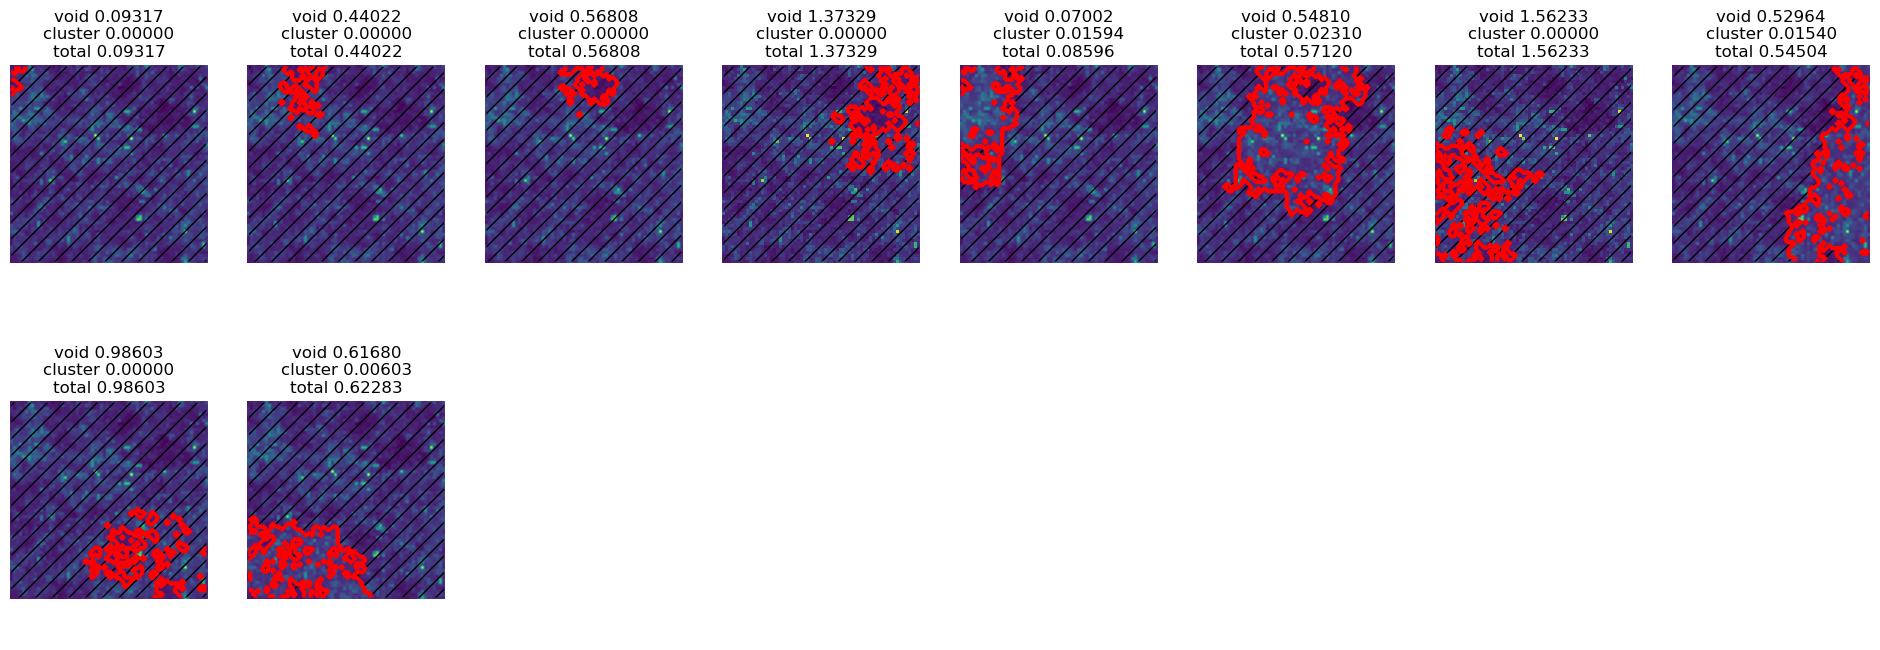

In [47]:
import matplotlib.pyplot as plt
import math

import torch
from exlib.datasets.massmaps import MassMapsAlignment
quickshift_baseline = MassMapsQuickshift()

X, y = train_dataset[0:2]['input'], train_dataset[0:2]['label']
zp = quickshift_baseline(X)
print('X', X.shape)
print('y', y.shape)
print('zp', zp.shape)
massmaps_align = MassMapsAlignment()
alignment_scores_void, alignment_scores_cluster = massmaps_align(zp, X, reduce='none')
print('alignment_scores_void', alignment_scores_void.shape)
print('alignment_scores_cluster', alignment_scores_cluster.shape)

img_idx = 0
m = zp.shape[1]
cols = 8
rows = math.ceil(m / cols)
fig, axs = plt.subplots(rows, cols, figsize=(cols*3, rows*4))
axs = axs.ravel()

image = X[img_idx]
for idx in range(len(axs)):
    if idx < m:
        mask = zp[img_idx][idx]

        if mask.sum() > 0:
            axs[idx].imshow(image[0].cpu().numpy())
            axs[idx].contour(mask.cpu().numpy() > 0, 2, colors='red')
            axs[idx].contourf(mask.cpu().numpy() > 0, 2, hatches=['//', None, None],
                            cmap='gray', extend='neither', linestyles='--', alpha=0.01)
            total_score = alignment_scores_void[0][idx].item() * massmaps_align.void_scale + alignment_scores_cluster[0][idx].item() * massmaps_align.cluster_scale
            axs[idx].set_title(f'void {alignment_scores_void[0][idx].item():.5f}\ncluster {alignment_scores_cluster[0][idx].item():.5f}\ntotal {total_score:.5f}')
    axs[idx].axis('off')
plt.show()
          

In [66]:
# Patch

# from skimage.segmentation import watershed, quickshift
from scipy import ndimage
# from skimage.feature import peak_local_max
# from 
import sys
sys.path.append('../src')
from exlib.explainers.common import convert_idx_masks_to_bool, patch_segmenter
import torch
import torch.nn as nn
import numpy as np
import cv2

class MassMapsPatch(nn.Module):
    def __init__(self, sz=(8, 8)):
        super().__init__()
        self.sz = sz
    
    def apply_patch(self, image):
        """
        ratio : float, optional, between 0 and 1
            Balances color-space proximity and image-space proximity.
            Higher values give more weight to color-space.
        kernel_size : float, optional
            Width of Gaussian kernel used in smoothing the
            sample density. Higher means fewer clusters.
        max_dist : float, optional
            Cut-off point for data distances.
            Higher means fewer clusters.
        """
        return patch_segmenter(image, sz=self.sz)
    
    def forward(self, images):
        """
        input: images (N, C=1, H, W)
        output: daf_preds (N, H, W)
        """
        daf_preds = []
        for image in images:
            segment_mask = torch.tensor(self.apply_patch(image[0].cpu().numpy())).to(images.device)
            masks_bool = convert_idx_masks_to_bool(segment_mask[None])
            daf_preds.append(masks_bool)
        daf_preds = torch.nn.utils.rnn.pad_sequence(daf_preds, batch_first=True)
        return daf_preds

X torch.Size([2, 1, 66, 66])
y torch.Size([2, 2])
zp torch.Size([2, 64, 66, 66])
alignment_scores_void torch.Size([2, 64])
alignment_scores_cluster torch.Size([2, 64])


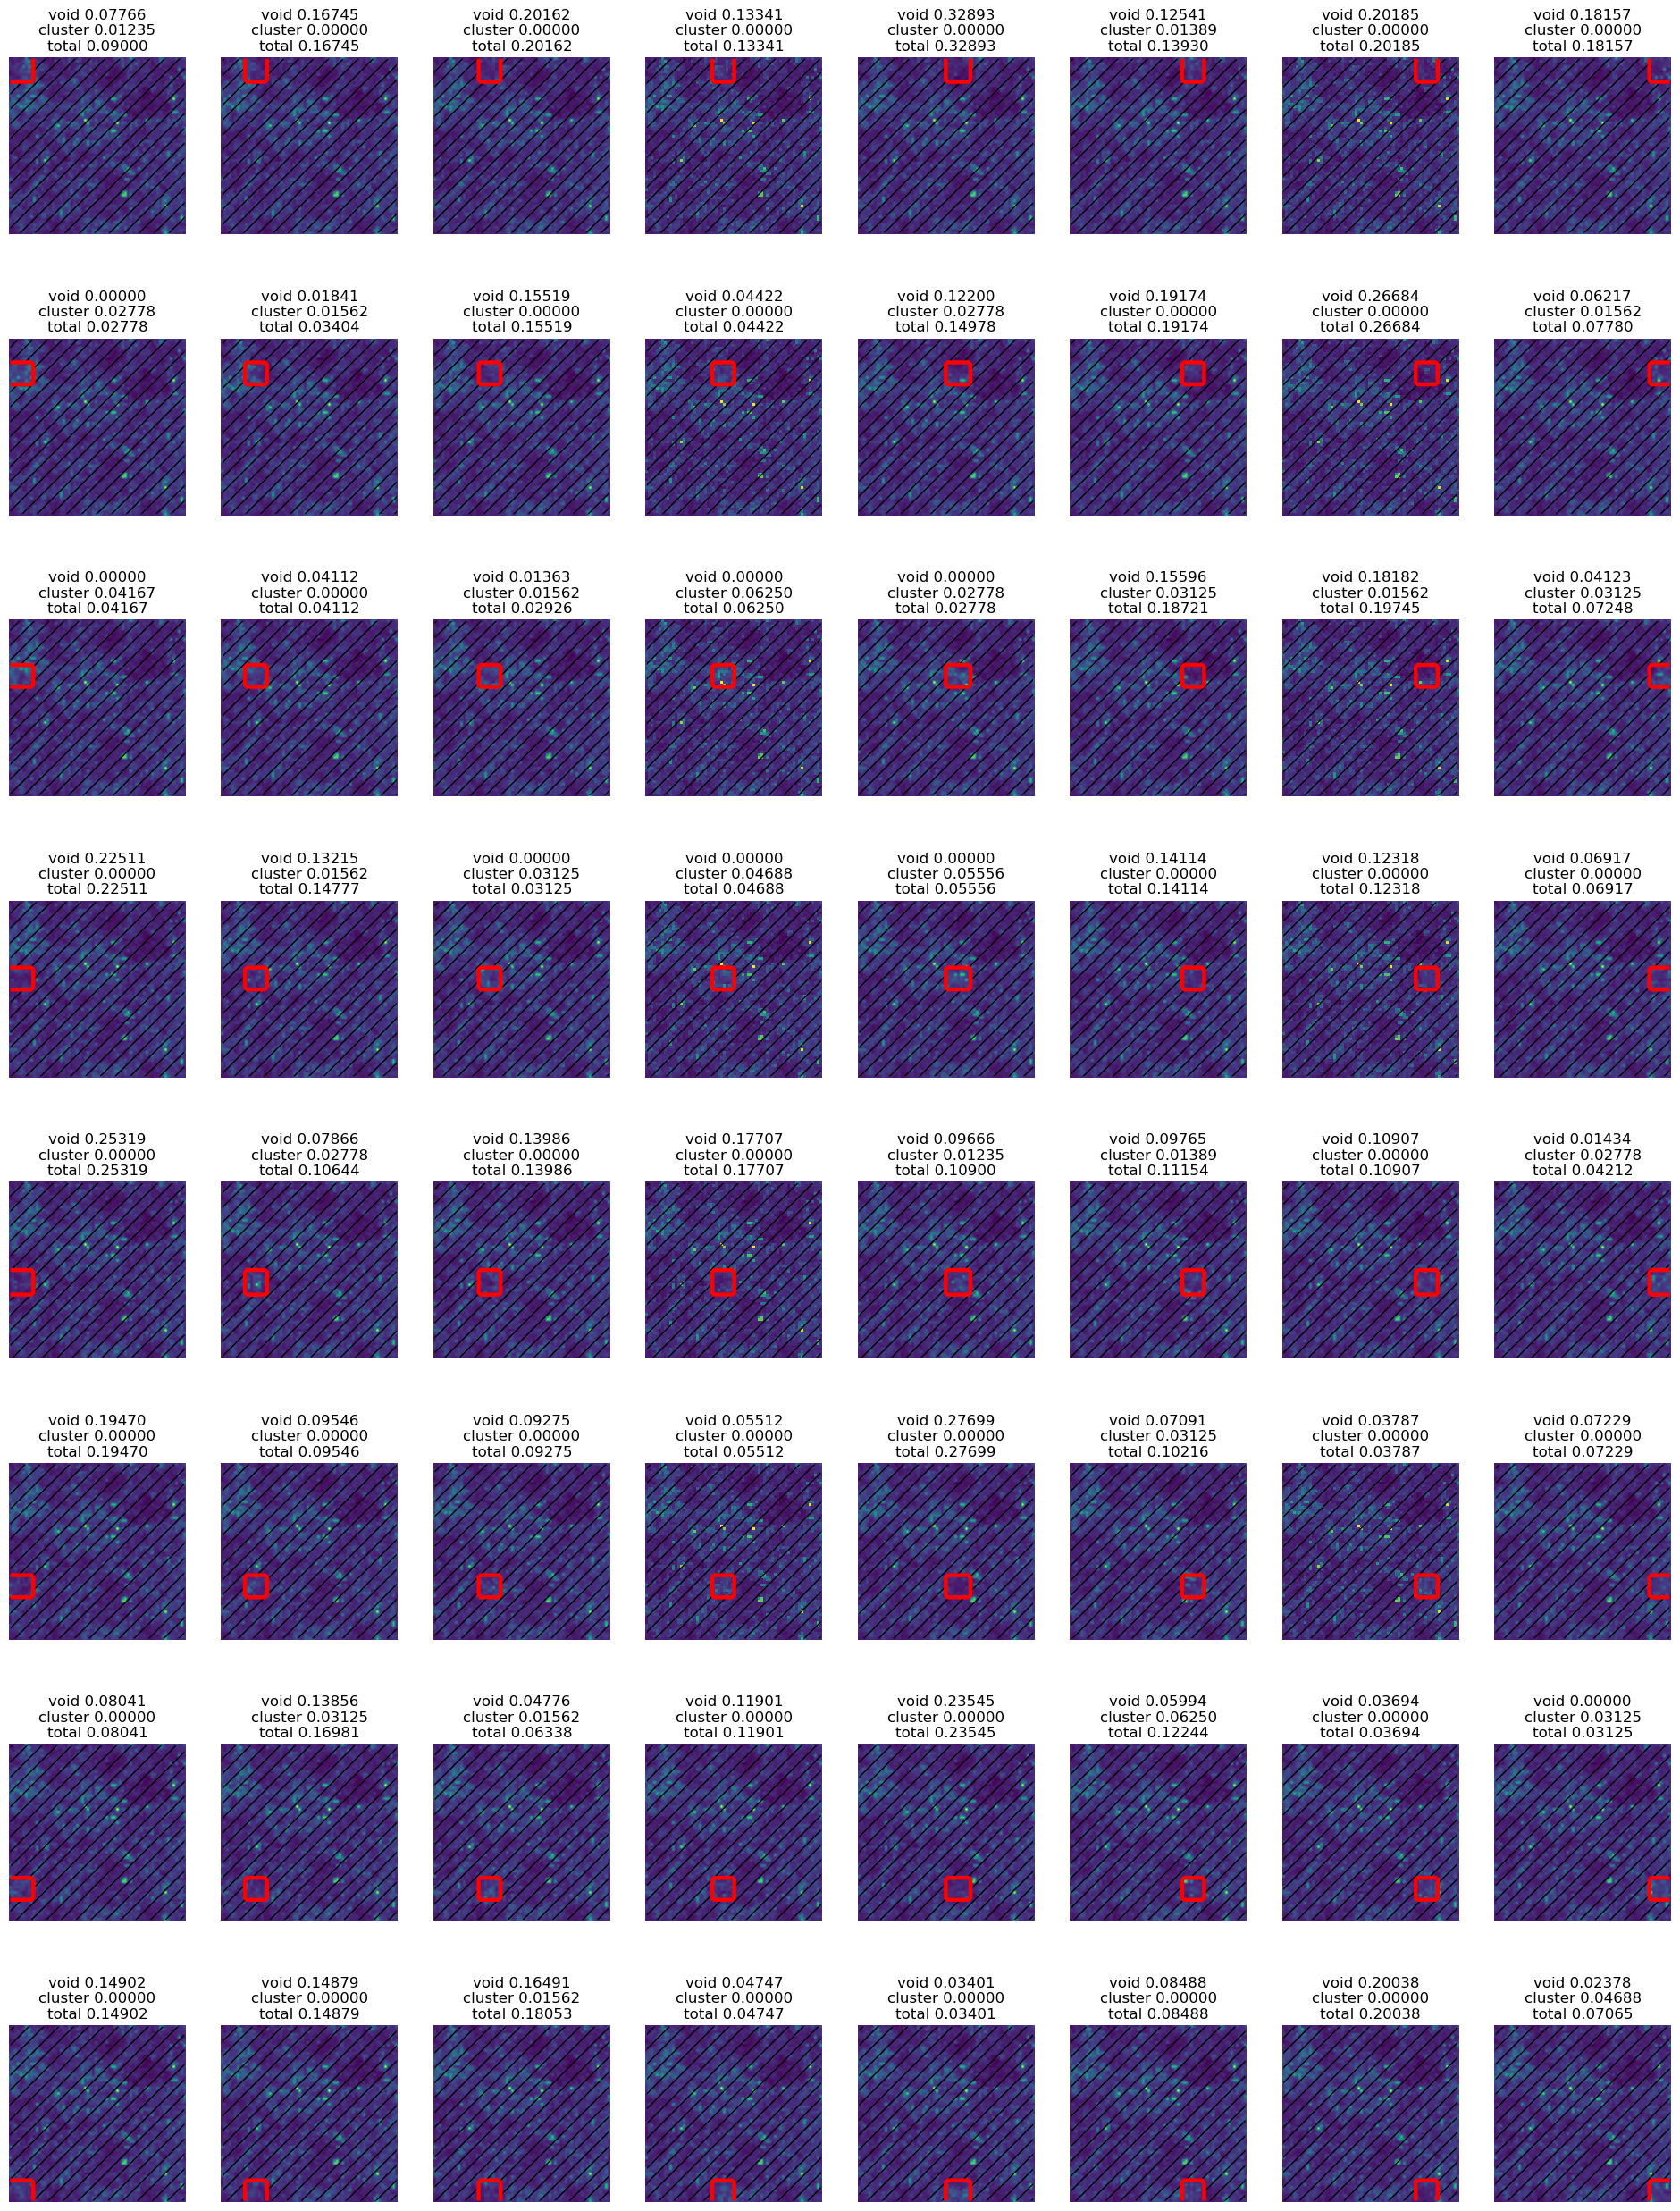

In [67]:
import matplotlib.pyplot as plt
import math

import torch
# from exlib.datasets.massmaps import MassMapsAlignment
patch_baseline = MassMapsPatch()

X, y = train_dataset[0:2]['input'], train_dataset[0:2]['label']
zp = patch_baseline(X)
print('X', X.shape)
print('y', y.shape)
print('zp', zp.shape)
massmaps_align = MassMapsAlignment()
alignment_scores_void, alignment_scores_cluster = massmaps_align(zp, X, reduce='none')
print('alignment_scores_void', alignment_scores_void.shape)
print('alignment_scores_cluster', alignment_scores_cluster.shape)

img_idx = 0
m = zp.shape[1]
cols = 8
rows = math.ceil(m / cols)
fig, axs = plt.subplots(rows, cols, figsize=(cols*3, rows*4))
axs = axs.ravel()

image = X[img_idx]
for idx in range(len(axs)):
    if idx < m:
        mask = zp[img_idx][idx]

        if mask.sum() > 0:
            axs[idx].imshow(image[0].cpu().numpy())
            axs[idx].contour(mask.cpu().numpy() > 0, 2, colors='red')
            axs[idx].contourf(mask.cpu().numpy() > 0, 2, hatches=['//', None, None],
                            cmap='gray', extend='neither', linestyles='--', alpha=0.01)
            total_score = alignment_scores_void[0][idx].item() * massmaps_align.void_scale + alignment_scores_cluster[0][idx].item() * massmaps_align.cluster_scale
            axs[idx].set_title(f'void {alignment_scores_void[0][idx].item():.5f}\ncluster {alignment_scores_cluster[0][idx].item():.5f}\ntotal {total_score:.5f}')
    axs[idx].axis('off')
plt.show()
          

# Compare baselines

In [68]:
from collections import defaultdict

# Eval
watershed_baseline = MassMapsWatershed().to(device)
quickshift_baseline = MassMapsQuickshift().to(device)
patch_baseline = MassMapsPatch().to(device)

baselines = {
    'watershed': watershed_baseline,
    'quickshift': quickshift_baseline,
    'patch': patch_baseline
}

batch_size = 5
test_dataloader = torch.utils.data.DataLoader(test_dataset, batch_size=batch_size)

import torch.nn.functional as F
from tqdm.auto import tqdm

model.eval()
mse_loss_all = 0
total = 0
alignment_scores_all = defaultdict(list)
groups = defaultdict(list)

with torch.no_grad():
    for bi, batch in tqdm(enumerate(test_dataloader), total=len(test_dataloader)):
        X = batch['input'].to(device)
        y = batch['label'].to(device)
        out = model(X)
        # loss
        loss = F.mse_loss(out, y, reduction='none')
        mse_loss_all = mse_loss_all + loss.sum(0)
        total += X.shape[0]

        # baseline
        for name, baseline in baselines.items():
            zp = baseline(X)

            # alignment
            alignment_scores = massmaps_align(zp, X)
            for i in range(X.shape[0]):
                alignment_scores_all[name].append(alignment_scores[i][zp[i].sum([-1,-2]) > 0].cpu().numpy().tolist())
                groups[name].append(zp[i][zp[i].sum([-1,-2]) > 0].cpu().numpy().tolist())
                
        if bi > 100:
            break
            
loss_avg = mse_loss_all / total

print(f'Omega_m loss {loss_avg[0].item():.4f}, sigma_8 loss {loss_avg[1].item():.4f}, avg loss {loss_avg.mean().item():.4f}')

  0%|          | 0/2000 [00:00<?, ?it/s]

Omega_m loss 0.0048, sigma_8 loss 0.0114, avg loss 0.0081


In [69]:
for name in alignment_scores_all:
    mean_align = torch.mean(torch.stack([torch.mean(torch.tensor(alignment_scores_all[name][i])) \
                          for i in range(len(alignment_scores_all[name]))]))
    print(name, mean_align)


watershed tensor(0.1300)
quickshift tensor(1.2543)
patch tensor(0.0904)


In [70]:
for name in alignment_scores_all:
    max_align = torch.mean(torch.stack([torch.max(torch.tensor(alignment_scores_all[name][i])) \
                          for i in range(len(alignment_scores_all[name]))]))
    print(name, max_align)


watershed tensor(1.1240)
quickshift tensor(4.8077)
patch tensor(0.4405)
